<a href="https://colab.research.google.com/github/tarek3laa/Digits_Classification_MNIST_Dataset/blob/master/project_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**import libiares**

In [3]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import layers as L, Sequential,optimizers,losses
from keras.callbacks import ModelCheckpoint,CSVLogger
import os


Using TensorFlow backend.


**Download Data**

In [4]:
!kaggle competitions download -c digit-recognizer

 55% 5.00M/9.16M [00:00<00:00, 30.9MB/s]
100% 9.16M/9.16M [00:00<00:00, 45.0MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.5MB/s]
 82% 5.00M/6.09M [00:00<00:00, 25.8MB/s]
100% 6.09M/6.09M [00:00<00:00, 29.8MB/s]


In [5]:
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [6]:
!rm /content/test.csv.zip
!rm /content/train.csv.zip

**loading and exploring dataset**

In [7]:
def load_data():
  test = pd.read_csv("/content/test.csv")
  train = pd.read_csv("/content/train.csv")

  y = to_categorical(np.array(train['label']))
  X = np.array(train.drop('label', axis=1)).reshape(-1, 28, 28,1)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,shuffle = True)
  X_test = np.array(test).reshape(-1, 28, 28,1)

  return X_train, X_val, y_train, y_val, X_test

In [9]:
X_train, X_val, y_train, y_val, X_test = load_data()

In [10]:
print("X_train shape: %s" % (str(X_train.shape)))
print("y_train shape: %s" % (str(y_train.shape)))

X_train shape: (31500, 28, 28, 1)
y_train shape: (31500, 10)


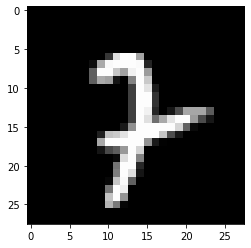

In [11]:
plt.imshow(X_train[10,:,:,0],cmap='gray')

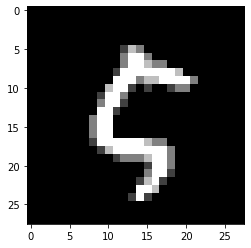

In [12]:
plt.imshow(X_train[200,:,:,0],cmap='gray')

**Preparing Images**

In [13]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [14]:
def standardize(x):
    return (x-mean_px)/std_px


**Define the model**

In [41]:
model = Sequential()      
model.add(L.Lambda(standardize,input_shape=(28,28,1)))       
model.add(L.Conv2D(8, (5, 5), activation='relu'))
model.add(L.BatchNormalization())           
model.add(L.MaxPool2D(strides=2))
model.add(L.Conv2D(16, (5, 5), activation='relu'))
model.add(L.BatchNormalization())
model.add(L.MaxPool2D(strides=2))
model.add(L.Flatten())
model.add(L.Dense(64, activation = 'relu'))
model.add(L.Dense(128, activation = 'relu'))
model.add(L.Dense(10,  activation='softmax'))

In [81]:
model.compile(optimizer=optimizers.Adam(0.000015), loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 8)         32        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 16)          3216      
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 16)          64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)         

**Training**

In [76]:
check_point = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/mnist/weights_6-{epoch:02d}')

In [48]:
loss = []
val_loss = []
acc = []
val_acc = []

In [70]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/mnist/weights_5-03')

In [85]:
history = model.fit(batches,epochs=3,validation_data=val_batches,callbacks=[check_point])

Epoch 1/3
493/493 [==============================] - 13s 25ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.0731 - val_accuracy: 0.9889
Epoch 2/3
493/493 [==============================] - 12s 25ms/step - loss: 0.0261 - accuracy: 0.9914 - val_loss: 2.1538e-04 - val_accuracy: 0.9885
Epoch 3/3
493/493 [==============================] - 12s 25ms/step - loss: 0.0241 - accuracy: 0.9929 - val_loss: 1.6927e-05 - val_accuracy: 0.9900


In [86]:
loss += history.history['loss']
val_loss += history.history['val_loss']

acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

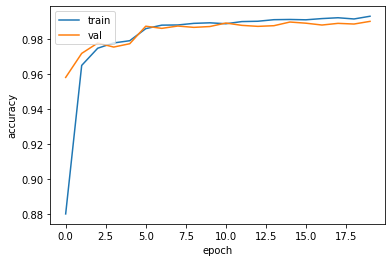

In [87]:
plt.plot(acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')

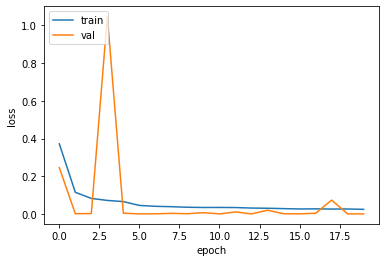

In [88]:
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')

**submit the prediction**

In [89]:
predictions = model.predict_classes(X_test, verbose=0)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("submission.csv", index=False, header=True)

In [91]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Message"

100% 208k/208k [00:02<00:00, 74.2kB/s]
Successfully submitted to Digit Recognizer